Train the classifyer

In [ ]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
from tqdm import tqdm
from torchvision import datasets, transforms, models
import argparse
from pathlib import Path
from torch.utils.data import DataLoader
from pyphoon2.DigitalTyphoonDataset import DigitalTyphoonDataset
import matplotlib.pyplot as plt
from datetime import datetime

def main(args):
    # Hyperparams
    max_epochs     = args.max_epochs
    batch_size     = args.batch_size
    lr             = args.lr
    checkpoint_dir = args.checkpoint_dir  # e.g. './checkpoints'
    device         = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    standardize_range = (150, 350)
    downsample_size = (224, 224)
    num_workers=0
    data_path = args.dataroot
    images_path = data_path + '/image/' # to the image folder
    metadata_path = data_path + '/metadata/' # to the metadata folder
    json_path = data_path + '/metadata.json'  # to the metadata json

    # Define a filter to pass to the loader.
    #     Any image that the function returns true will be included
    def image_filter(image):
        return image.grade() < 7

    # Define a function to transform each image, to pass to the loader.
    # Crucially, this transform function is applied to each *image*, prior to any Pytorch processing.
    # So, image-by-image transforms (i.e. clipping, downsampling, etc. can/should be done here)
    def transform_func(image_ray):
        # Clip the pixel values between 150 and 350
        image_ray = np.clip(image_ray, standardize_range[0], standardize_range[1])

        # Standardize the pixel values between 0 and 1
        image_ray = (image_ray - standardize_range[0]) / (standardize_range[1] - standardize_range[0])

        # Downsample the images to 224, 224
        if downsample_size != (512, 512):
            image_ray = torch.Tensor(image_ray)
            image_ray = torch.reshape(image_ray, [1, 1, image_ray.size()[0], image_ray.size()[1]])
            image_ray = nn.functional.interpolate(image_ray, size=downsample_size, mode='bilinear', align_corners=False)
            image_ray = torch.reshape(image_ray, [image_ray.size()[2], image_ray.size()[3]])
            image_ray = image_ray.numpy()
        return image_ray

    # Load Dataset
    dataset = DigitalTyphoonDataset(str(images_path),
                                    str(metadata_path),
                                    str(json_path),
                                    'grade',  
                                    filter_func=image_filter, 
                                    transform_func=transform_func,
                                    verbose=False)


    train_set, test_set, val_set, _ = dataset.random_split(
        [0.1, 0.004, 0.004, 0.892],
        split_by='sequence'
    )
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False)

    # Build model
    model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=None)
    model.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
    model.fc    = nn.Linear(512, 7)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    # Book-keeping
    train_losses = []
    val_losses   = []
    best_val     = float('inf')

    for epoch in range(max_epochs):
        # —— Training pass —— 
        model.train()
        running_train_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epochs} [Train]"):
            images, labels = images.unsqueeze(1).float().to(device), labels.long().to(device)
            optimizer.zero_grad()
            preds = model(images)
            loss  = criterion(preds, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * images.size(0)

        avg_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # —— Validation pass —— 
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{max_epochs} [ Val ]"):
                images, labels = images.unsqueeze(1).float().to(device), labels.long().to(device)
                preds = model(images)
                running_val_loss += criterion(preds, labels).item() * images.size(0)

        avg_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
        # —— Checkpointing —— 
        # 1) Save “best so far”
        if avg_val_loss < best_val:
            best_val = avg_val_loss

            torch.save(model.state_dict(),
                       f"{checkpoint_dir}/best_model_{current_time}.pt")
        # 2) Optionally, save every N epochs
        if (epoch + 1) % args.save_every == 0:
            torch.save(model.state_dict(),
                       f"{checkpoint_dir}/epoch_{epoch+1:03d}.pt")

        print(f"Epoch {epoch+1:03d} → train: {avg_train_loss:.4f}, val: {avg_val_loss:.4f}")
        
    plt.figure()
    plt.plot(range(1, max_epochs+1), train_losses, label="Train Loss")
    plt.plot(range(1, max_epochs+1), val_losses,   label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig(args.loss_plot_path) 
    plt.close()

    return train_losses, val_losses

if __name__ == "__main__":
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument('--dataroot',       type=str,default='F:/Data folder for ML/AU/AU')
    parser.add_argument('--max_epochs',     type=int, default=100)
    parser.add_argument('--batch_size',     type=int, default=10)
    parser.add_argument('--lr',             type=float, default=0.1)
    parser.add_argument('--save_every',     type=int, default=2,
                        help="checkpoint frequency (epochs)")
    parser.add_argument('--checkpoint_dir', type=str, default='c:/Users/nilss/Desktop/Advanded ML FOLDer/outputs-Typhoon_analysis/checkpoints')
    parser.add_argument('--loss_plot_path', type=str, default='c:/Users/nilss/Desktop/Advanded ML FOLDer/outputs-Typhoon_analysis/loss_curve.png')
    args = parser.parse_args([])

    train_losses, val_losses = main(args)


Using cache found in C:\Users\nilss/.cache\torch\hub\pytorch_vision_v0.10.0
Epoch 1/100 [Train]:   9%|▊         | 61/708 [01:19<13:58,  1.30s/it]


KeyboardInterrupt: 

Load previous model weigths

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from pathlib import Path
from datetime import datetime
from pyphoon2.DigitalTyphoonDataset import DigitalTyphoonDataset


data_path     = 'F:/Data folder for ML/AU/AU'
images_path   = data_path + '/image/'      # to the image folder
metadata_path = data_path + '/metadata/'   # to the metadata folder
json_path     = data_path + '/metadata.json'  # to the metadata json

standardize_range = (150, 350)
downsample_size   = (224, 224)

def transform_func(image_ray):
    image_ray = np.clip(image_ray, standardize_range[0], standardize_range[1])
    image_ray = (image_ray - standardize_range[0]) / (standardize_range[1] - standardize_range[0])
    if downsample_size != (512, 512):
        image_ray = torch.Tensor(image_ray)
        image_ray = image_ray.unsqueeze(0).unsqueeze(0)  # [1,1,H,W]
        image_ray = nn.functional.interpolate(
            image_ray, size=downsample_size, mode='bilinear', align_corners=False
        )
        image_ray = image_ray.squeeze().numpy()
    return image_ray

def image_filter(image):
    return image.grade() < 8

dataset = DigitalTyphoonDataset(
    str(images_path),
    str(metadata_path),
    str(json_path),
    'grade',
    filter_func=image_filter,
    transform_func=transform_func,
    verbose=False
)

loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)
print("Dataset length:", len(dataset))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18')
model.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
model.fc    = nn.Linear(512, 7)
model.to(device)

model.load_state_dict(torch.load(
    'C:/Users/nilss/Desktop/Advanded ML FOLDer/outputs-Typhoon_analysis/checkpoints/epoch_010.pt',
    map_location=device
))
model.eval()


records = []
for idx in range(len(dataset)):
    img_obj = dataset.get_image_from_idx(idx)
    seq_id  = img_obj.sequence_id()
    fname   = Path(img_obj.filepath()).name     
    arr     = img_obj.image()                

    x = torch.from_numpy(arr).unsqueeze(0).unsqueeze(0).float().to(device)
    with torch.no_grad():
        logits     = model(x)
        pred_grade = logits.argmax(dim=1).item()

    date_str = fname.split('-')[0]           
    date     = datetime.strptime(date_str, '%Y%m%d%H')

    records.append({
        'sequence_id': seq_id,
        'date'       : date,
        'grades'     : pred_grade
    })


df = pd.DataFrame(records)
summary = (
    df.groupby('sequence_id')
      .agg(
         avg_grade=('grades', 'mean'),
         last_date =('date',   'max')
      )
      .reset_index()
      .sort_values('last_date')
)
summary.to_csv('typhoon_sequence_summary.csv', index=False)


Dataset length: 70087


Using cache found in C:\Users\nilss/.cache\torch\hub\pytorch_vision_v0.10.0


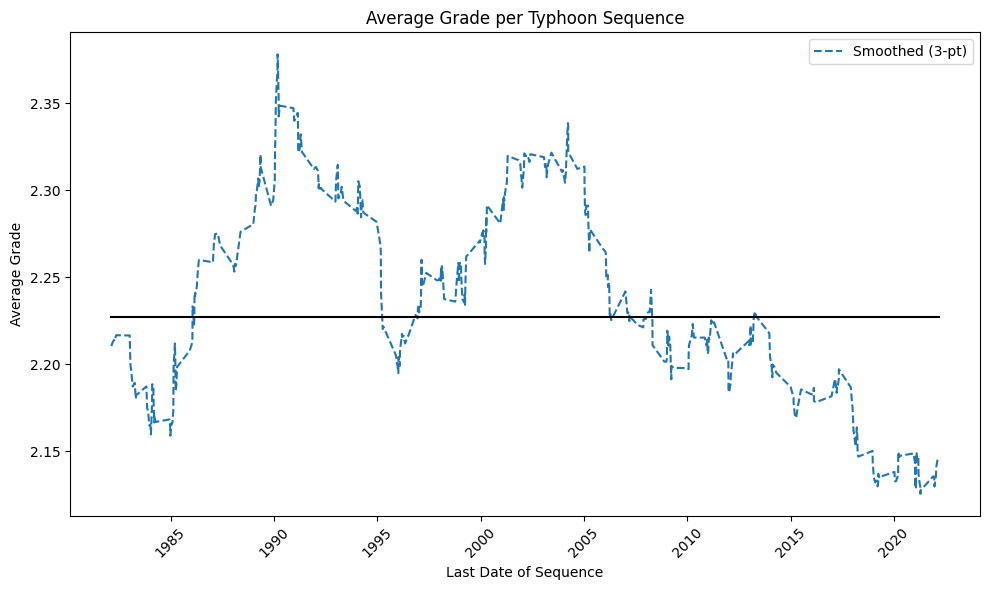

In [ ]:
# compute a centered 3‐point rolling mean
summary['smoothed'] = summary['avg_grade'].rolling(window=50, center=True).mean()

plt.figure(figsize=(10,6))

plt.plot(summary['last_date'], summary['smoothed'], linestyle='--', label='Smoothed (3‐pt)')

plt.xlabel('Last Date of Sequence')
plt.ylabel('Average Grade')
plt.title('Average Grade per Typhoon Sequence')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
